In [161]:
import seaborn as sns
from nufeb_tools import utils,plot,spatial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm,ListedColormap
import matplotlib as mpl
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance
import matplotlib.image as mpimg
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed

In [2]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [3]:
DIR = Path(r'E:\fitness-prediction\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]

In [4]:
def collect_data(folder):
    
    try:
        a = utils.get_data(directory=str(folder))
        b = spatial.fitness_metrics(a)
        return b
    except:
        print('Error in ' + str(folder))
        return

# Gather datasets

In [5]:
if Path(r'E:\fitness-prediction\saved-metrics.pkl').is_file():
    data = pd.read_pickle(r'E:\fitness-prediction\saved-metrics.pkl')
else:
    with ProgressParallel(n_jobs=6) as parallel:
        temp = parallel(delayed(collect_data)(folder) for folder in sorted(folders))
    data = pd.concat(temp)
    data.to_pickle(r'E:\fitness-prediction\saved-metrics.pkl')





In [6]:
cmaps = ["light:#03012d","light:#d99e09"]
cmaps2 = ["#03012d","#d99e09"]


In [7]:
metric2 = data[data.type==2].fillna(0)

metric_list = list(metric2.columns.drop('total biomass'))

# Plot all possible metrics vs biomass

In [8]:
data.columns

Index(['mother_cell', 'type', 'Voronoi Area', 'IPTG', 'Time',
       'Distance from center', 'total biomass', 'Nearest 1', 'Nearest 2',
       'Nearest Neighbor', 'IC1', 'IC2', 'IC', 'Relative Neighbor Dist 1',
       'Relative Neighbor Dist 2', 'Relative Neighbor Dist', 'Z1', 'Z2',
       'Z1_2', 'Z2_1', 'LogNearest 1', 'LogNearest 2', 'LogNearest', 'Inv1',
       'Inv2', 'Log Inv1', 'Log Inv2', 'Colony Area', 'initial biomass'],
      dtype='object')

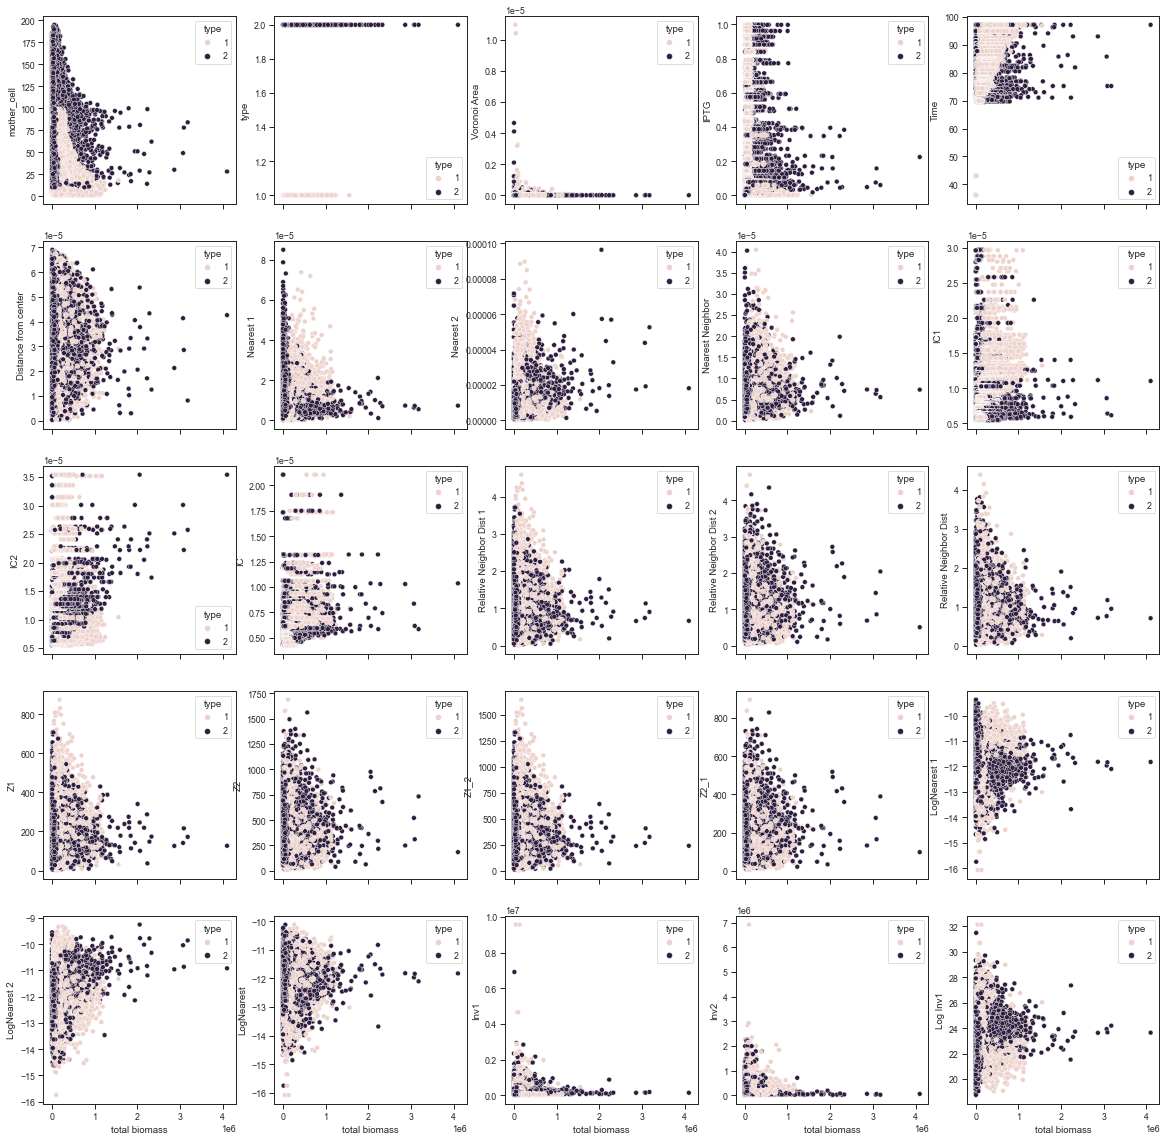

" for ax in axes.ravel():\n   ax.set_xscale('log')\n   ax.set_yscale('log') "

# IC 1

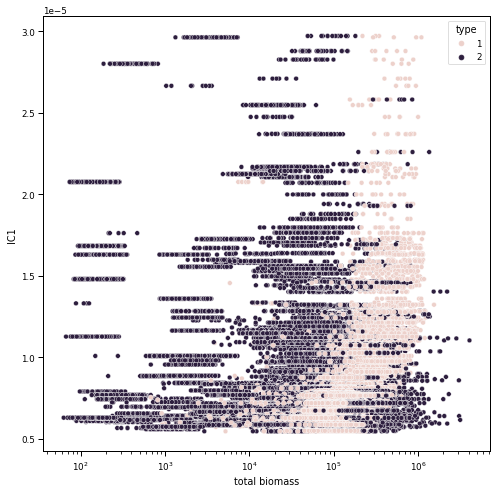

In [10]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IC1',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


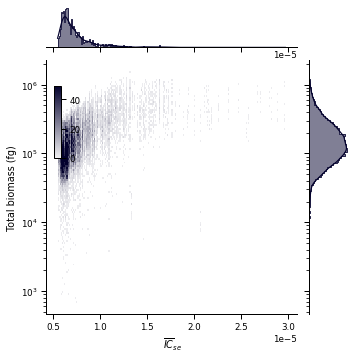

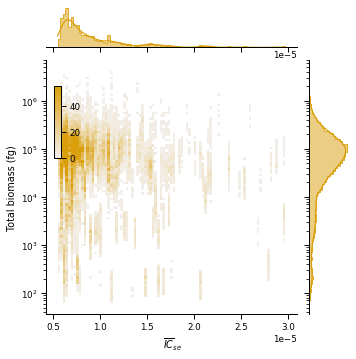

In [11]:
types = [r'$\it{S. elongatus}$',r'$\it{E. coli W}$']
for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IC1",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r' $\overline{IC}_{se}$')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/IC1_{i}.png',dpi=600)

# IC 2

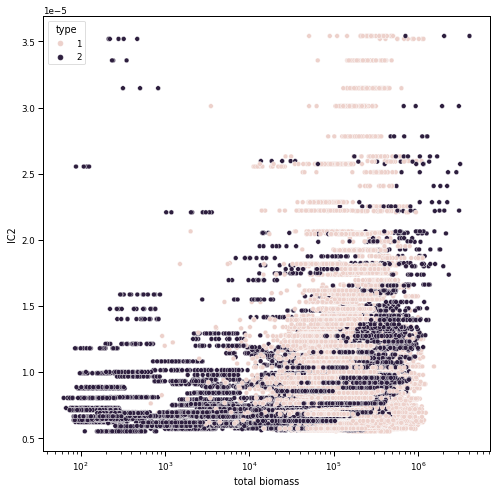

In [12]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IC2',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


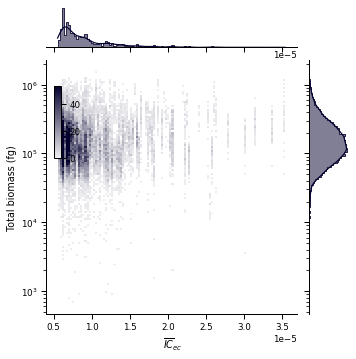

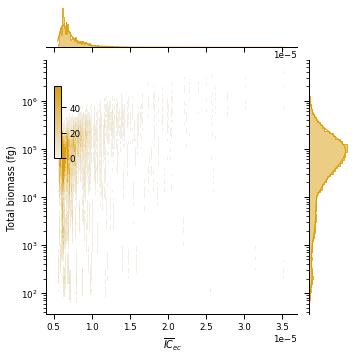

In [13]:
sns.set_context('paper')
for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IC2",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r' $\overline{IC}_{ec}$')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/IC2_{i}.png',dpi=600)

Text(0, 0.5, ' $\\overline{IC}_{ec}$')

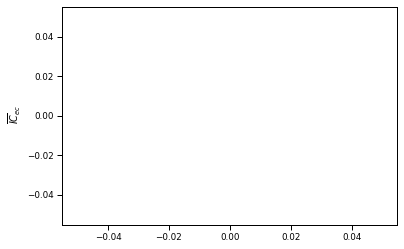

In [14]:
f, ax =plt.subplots()
ax.plot()
ax.set_ylabel(r' $\overline{IC}_{ec}$')


# Sucrose export

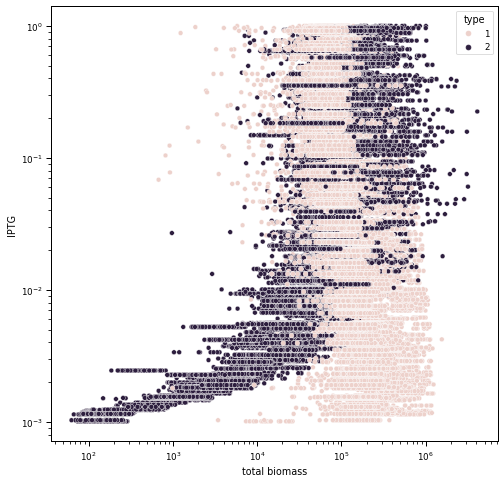

In [15]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IPTG',hue='type',data=data,ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


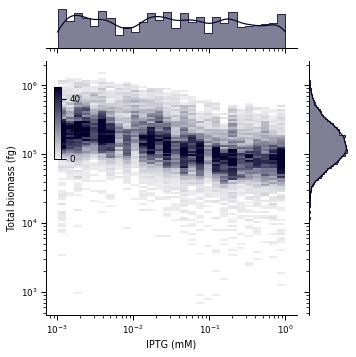

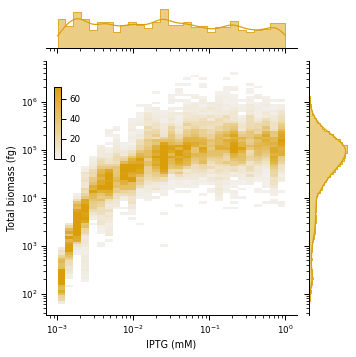

In [16]:

for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IPTG",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    g.ax_joint.set(xscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r'IPTG (mM)')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/sucR_{i}.png',dpi=600)

In [17]:
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.1, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

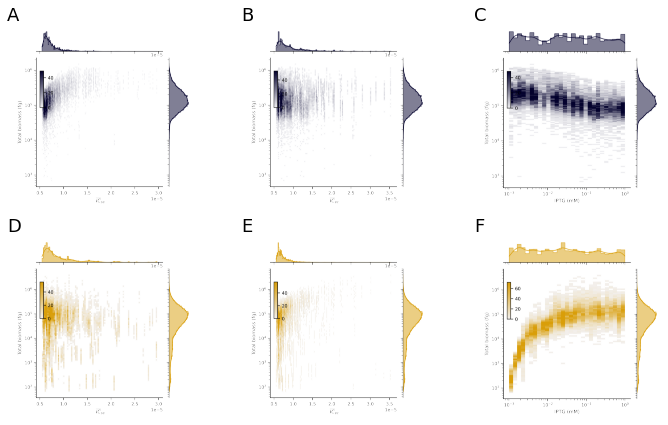

In [18]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
axes[0,0].imshow(mpimg.imread('../figures/IC1_1.png'))
axes[0,1].imshow(mpimg.imread('../figures/IC2_1.png'))
axes[0,2].imshow(mpimg.imread('../figures/sucR_1.png'))

axes[1,0].imshow(mpimg.imread('../figures/IC1_2.png'))
axes[1,1].imshow(mpimg.imread('../figures/IC2_2.png'))
axes[1,2].imshow(mpimg.imread('../figures/sucR_2.png'))
for ax in axes.ravel():
    ax.axis('off')

label_panel(axes[0,0],'A')
label_panel(axes[0,1],'B')
label_panel(axes[0,2],'C')
label_panel(axes[1,0],'D')
label_panel(axes[1,1],'E')
label_panel(axes[1,2],'F')
f.tight_layout()
f.savefig('../figures/spatial metrics.png',dpi=600)

Score:  1.0
Mean cross-validataion score: 0.91


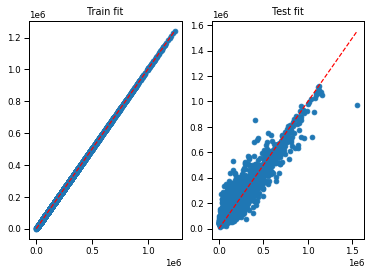

           0         1                         2
3   0.836254  0.008407                      Time
25  0.410767  0.008021           initial biomass
2   0.401737  0.008526                      IPTG
4    0.10767  0.003438      Distance from center
8   0.052351   0.00065                       IC1
10  0.002879  0.000055                        IC
21  0.001757   0.00003                      Inv1
23  0.000919  0.000013                  Log Inv1
18  0.000881  0.000011              LogNearest 1
9   0.000824  0.000033                       IC2
17  0.000499  0.000011                      Z2_1
12  0.000493   0.00001  Relative Neighbor Dist 2
15   0.00048  0.000009                        Z2
5   0.000466  0.000004                 Nearest 1
20  0.000426  0.000005                LogNearest
13  0.000404  0.000011    Relative Neighbor Dist
16  0.000382  0.000006                      Z1_2
22  0.000382  0.000008                      Inv2
11  0.000378   0.00001  Relative Neighbor Dist 1
24  0.000356  0.0000

In [19]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 

data2 = data[data.type==1]
X = data2[predictors]
y = data2['total biomass']
train_X1, test_X1, train_y1, test_y1 = train_test_split(X, y, train_size = 0.7, random_state = 42)

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et1 = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
model_et1.fit(train_X1, train_y1) 

pred_train_et1= model_et1.predict(train_X1)
pred_test_et1 = model_et1.predict(test_X1)

score = model_et1.score(train_X1, train_y1)
print("Score: ", score)
cv_scores = cross_val_score(model_et1, train_X1,train_y1,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y1,pred_train_et1)
axes[1].scatter(test_y1,pred_test_et1)
#Plot the diagonal line
d_line= np.arange(train_y1.min(), train_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y1.min(), test_y1.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result1 = permutation_importance(model_et1, train_X1, train_y1, random_state=0)
feats1 = pd.DataFrame([result1.importances_mean,result1.importances_std,X.columns]).T
print(feats1.sort_values(by=0,ascending=False))

Score:  1.0
Mean cross-validataion score: 0.91


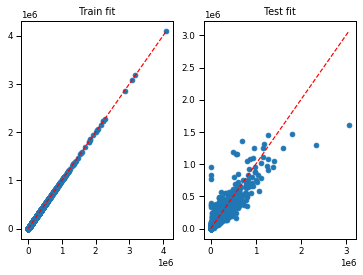

           0         1                         2
9    1.00066  0.018079                       IC2
2   0.799514  0.022699                      IPTG
25   0.20515  0.004068           initial biomass
4   0.090454  0.008268      Distance from center
8   0.018388  0.000652                       IC1
6   0.007614  0.000224                 Nearest 2
24  0.007052  0.000322                  Log Inv2
3   0.006655  0.000153                      Time
19  0.006055  0.000214              LogNearest 2
10  0.004623  0.000035                        IC
23  0.003197  0.000274                  Log Inv1
5   0.002861  0.000101                 Nearest 1
18  0.002466  0.000103              LogNearest 1
22  0.002294  0.000082                      Inv2
12  0.001972   0.00006  Relative Neighbor Dist 2
21  0.001814  0.000196                      Inv1
15  0.001678   0.00004                        Z2
17  0.001421  0.000035                      Z2_1
14  0.001168  0.000053                        Z1
16  0.001165  0.0000

In [20]:
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X2, test_X2, train_y2, test_y2 = train_test_split(X, y, train_size = 0.7, random_state = 42)

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et2 = ExtraTreesRegressor(n_estimators=1000, random_state=100,n_jobs=-1)
model_et2.fit(train_X2, train_y2) 

pred_train_et2= model_et2.predict(train_X2)
pred_test_et2 = model_et2.predict(test_X2)

score2 = model_et2.score(train_X2, train_y2)
print("Score: ", score)
cv_scores2 = cross_val_score(model_et2, train_X2,train_y2,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y2,pred_train_et2)
axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(train_y2.min(), train_y2.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result2 = permutation_importance(model_et2, train_X2, train_y2, random_state=0)
feats2 = pd.DataFrame([result2.importances_mean,result2.importances_std,X.columns]).T
print(feats2.sort_values(by=0,ascending=False))

In [88]:
X = data[predictors]
y = data['total biomass']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.7, random_state = 42)

Score:  1.0
Mean cross-validataion score: 0.87


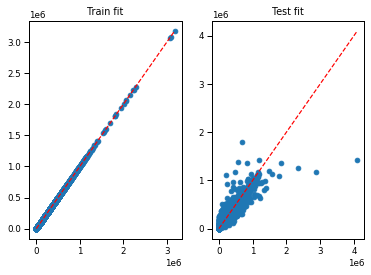

           0         1                         2
25  0.694175  0.009054           initial biomass
9   0.691329   0.01525                       IC2
0    0.68211  0.009976                      type
2    0.54699  0.011149                      IPTG
3   0.494786  0.004458                      Time
4    0.08657  0.002374      Distance from center
8   0.036705  0.000482                       IC1
10  0.006531  0.000059                        IC
6    0.00531  0.000146                 Nearest 2
24    0.0043  0.000109                  Log Inv2
19  0.003671   0.00009              LogNearest 2
23  0.001472  0.000025                  Log Inv1
21  0.001434  0.000017                      Inv1
18  0.001407  0.000024              LogNearest 1
22  0.001407  0.000028                      Inv2
5   0.001295  0.000028                 Nearest 1
15  0.000903  0.000017                        Z2
12  0.000859  0.000023  Relative Neighbor Dist 2
17  0.000857   0.00002                      Z2_1
14  0.000692  0.0000

In [21]:



#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et = ExtraTreesRegressor(n_estimators=1000, random_state=100,n_jobs=-1)
model_et.fit(train_X, train_y) 

pred_train_et= model_et.predict(train_X)
pred_test_et = model_et.predict(test_X)

score = model_et.score(train_X, train_y)
print("Score: ", score)
cv_scores = cross_val_score(model_et, train_X,train_y,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y,pred_train_et)
axes[1].scatter(test_y,pred_test_et)
#Plot the diagonal line
d_line= np.arange(train_y.min(), train_y.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y.min(), test_y.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
result = permutation_importance(model_et, train_X, train_y, random_state=0)
feats= pd.DataFrame([result.importances_mean,result.importances_std,X.columns]).T
print(feats.sort_values(by=0,ascending=False))

In [22]:
r2_score(test_y2,pred_test_et2)

0.8347368012854578

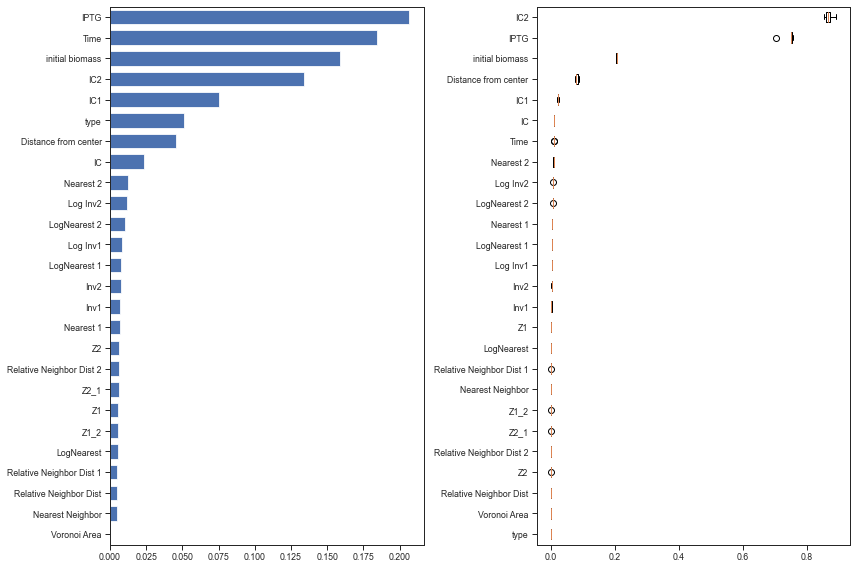

In [38]:
result = permutation_importance(model_et, train_X, train_y, random_state=0)
perm_sorted_idx = result.importances_mean.argsort()
#feats= pd.DataFrame([result.importances_mean,result.importances_std,X.columns]).T
tree_importance_sorted_idx = np.argsort(model_et.feature_importances_)
tree_indices = np.arange(0, len(model_et.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, model_et.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(model_et.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

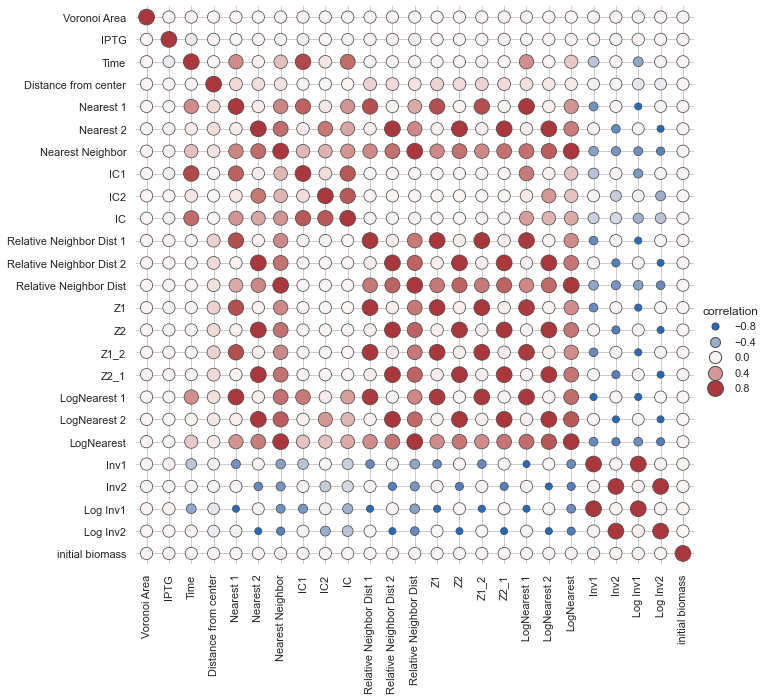

In [73]:
sns.set_theme(style="whitegrid")
dft = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (dft.columns
                  .get_level_values("network")
                  .astype(int)
                  .isin(used_networks))
dft = dft.loc[:, used_columns]

dft.columns = dft.columns.map("-".join)

# Compute a correlation matrix and convert to long-form
#corr_mat = dft.corr().stack().reset_index(name="correlation")
corr_mat = X.corr().stack().reset_index(name="correlation")
# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".3",
    height=10, sizes=(50, 250), size_norm=(-.8, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".3")

In [25]:
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols
def colorFaderRGB(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)

    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(tuple((((1-mix[i])*c1 + mix[i]*c2)*256).astype('int')))
    return cols


In [26]:
""" df=pd.DataFrame(np.vstack([test_y1,pred_test_et1,np.abs(test_y1-pred_test_et1)]).T,columns=['Total Biomass','Predicted Biomass','Diff'])
df2=pd.DataFrame(np.vstack([test_y2,pred_test_et2,np.abs(test_y2-pred_test_et2)]).T,columns=['Total Biomass','Predicted Biomass','Diff']) """

In [113]:
prediction=pd.DataFrame(np.vstack([test_y,pred_test_et,test_X.type]).T,columns=['Total Biomass','Predicted Biomass','type'])
df = prediction.loc[prediction.type==1]
df2 = prediction.loc[prediction.type==2]
cya = colorFader('#01665e','#c7eae5',len(df))
ecw = colorFader('#8c510a','#f6e8c3',len(df2))

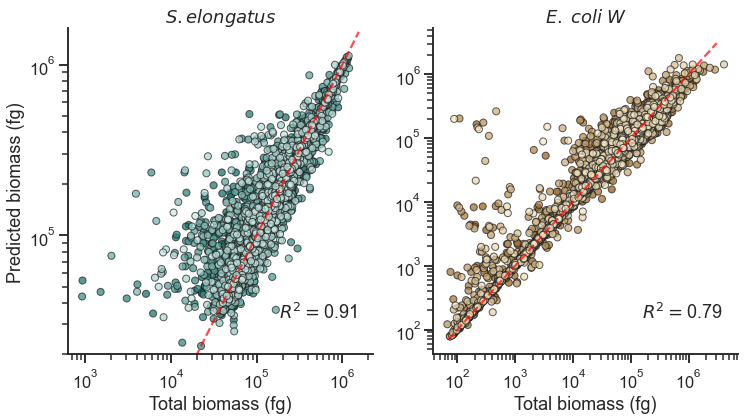

In [115]:
sns.set_theme(style="ticks")
sns.set_context('talk')
cmaps2 = ["#03012d","#d99e09"]
r2s = [r2_score(df['Total Biomass'],df['Predicted Biomass']),r2_score(df2['Total Biomass'],df2['Predicted Biomass'])]
ms = 50
f, axes = plt.subplots(ncols=2,figsize=(12,6))
#axes[0].scatter(test_y1,pred_test_et1)
#sns.scatterplot(x='Total Biomass',y='Predicted Biomass',ax=axes[0],palette=cya,data=df)
axes[0].scatter(x=df['Total Biomass'],y=df['Predicted Biomass'],s=ms,c=cya,alpha=0.7,ec='k',lw=1)
axes[1].scatter(x=df2['Total Biomass'],y=df2['Predicted Biomass'],s=ms,c=ecw,alpha=0.7,ec='k',lw=1)
#sns.scatterplot(x=test_y2,y=pred_test_et2,ax=axes[1],color="#d99e09")
#axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(test_y1.min(), test_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--',alpha=0.7)
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--',alpha=0.7)
axes[0].set_ylabel('Predicted biomass (fg)')
axes[0].set_ylim(bottom=2e4)
for r2,ax in zip(r2s,axes.ravel()):
    ax.set_xlabel('Total biomass (fg)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(0.95,0.1,f'$R^2=${r2:.2f}',transform=ax.transAxes,verticalalignment='bottom', horizontalalignment='right')
axes[0].set_title(r'$\it{S. elongatus}$')
axes[1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
sns.despine()
f.savefig('../figures/biomass-prediction.pdf',bbox_inches='tight')

In [183]:
selected_features=feats.sort_values(by=0,ascending=False).reset_index(drop=True).iloc[:8][2]

In [184]:
selected_features.drop([2,4,7],inplace=True)

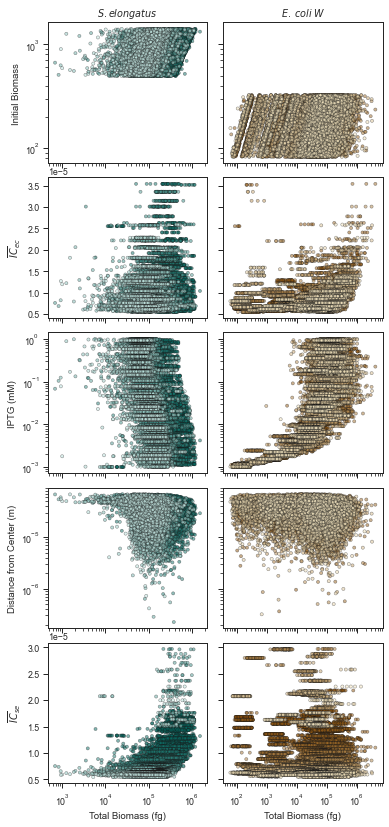

In [192]:
sns.set_context('paper')
ms = 10
a=0.5
labels=['Initial Biomass',r' $\overline{IC}_{ec}$','IPTG (mM)','Distance from Center (m)',r' $\overline{IC}_{se}$']
fig = plt.figure(figsize=(6,14))
my_gridspec = gridspec.GridSpec(len(selected_features), 2, figure=fig,wspace=.1,hspace=.1)
#f, axes = plt.subplots(ncols=2,nrows=len(selected_features),figsize=(4,16))
axes = my_gridspec.subplots(sharex='col', sharey='row')
for met,ax in zip(selected_features,axes[:,0]):
   d1 = data.loc[data.type==1]
    
   cya = colorFader('#01665e','#c7eae5',len(d1[met]))
    
   ax.scatter(x=d1['total biomass'],y=d1[met],s=ms,c=cya,alpha=a,ec='k',lw=.5,rasterized=True)
    
   ax.set_ylabel(met)
   #ax.set_xlim(1e3,1e7)
   #
for met,ax in zip(selected_features,axes[:,1]):
   d2 = data.loc[data.type==2]
   ecw = colorFader('#8c510a','#f6e8c3',len(d2[met]))
   ax.scatter(x=d2['total biomass'],y=d2[met],s=ms,c=ecw,alpha=a,ec='k',lw=.5,rasterized=True)
   ax.set_ylabel(met)
   
   #ax.set_xlim(1e1,1e7)
   #sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
for ax in axes.ravel():
   ax.set_xscale('log')
   
for ax in axes[:,1]:
   ax.set_ylabel('')
#axes[-1,0].set_xlabel('Total Biomass (fg)')  
for i in [0,2,3]:
   axes[i,0].set_yscale('log')
   axes[i,1].set_yscale('log')
axes[-1,0].set_xlabel('Total Biomass (fg)')
axes[-1,1].set_xlabel('Total Biomass (fg)')
axes[0,0].set_title(r'$\it{S. elongatus}$')
axes[0,1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
for ax,label in zip(axes[:,0],labels):
   ax.set_ylabel(label)
#fig.tight_layout()


#fig.savefig('../figures/spatial-metrics.pdf',bbox_inches='tight',dpi=1200)
fig.savefig('../figures/spatial-metrics.png',bbox_inches='tight',dpi=1200)
plt.show()
